In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#cd command needs '%' not '!', while other Unix commands need '!'
%cd ./drive/My\ Drive/summer\ vacation 3
!pwd
!ls -l

Mounted at /content/drive
/content/drive/My Drive/summer vacation 3
/content/drive/My Drive/summer vacation 3
total 1768
drwx------ 2 root root    4096 Aug  3 09:25  data
-rw------- 1 root root   17852 Aug  9 09:58  LOL_data_model.ipynb
-rw------- 1 root root   25905 Aug 12 07:03 'mushroom CNN.ipynb'
-rw------- 1 root root 1761303 Aug 11 07:46 '버섯데이터 전이학습.ipynb'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

 DataSet 불러오기


In [ ]:
# 데이터 경로 설정
Mushrooms_dataset = '/content/drive/MyDrive/summer vacation 3/data/archive/Mushrooms'

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(244),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

classes = sorted(os.listdir(Mushrooms_dataset))
classes_index = {c: i for i, c in enumerate(classes)}

classes, classes_index

(['Agaricus',
  'Amanita',
  'Boletus',
  'Cortinarius',
  'Entoloma',
  'Hygrocybe',
  'Lactarius',
  'Russula',
  'Suillus'],
 {'Agaricus': 0,
  'Amanita': 1,
  'Boletus': 2,
  'Cortinarius': 3,
  'Entoloma': 4,
  'Hygrocybe': 5,
  'Lactarius': 6,
  'Russula': 7,
  'Suillus': 8})

In [ ]:
count = 0
import math
import random

train_image_paths = []
test_image_paths = []

# Split images into train and test set
for path in os.listdir(Mushrooms_dataset):
    path = os.path.join(Mushrooms_dataset, path)
    img_count = len(os.listdir(path))
    images = [os.path.join(path, img) for img in os.listdir(path)]
    train_len = math.floor(img_count * 0.9)
    train_image_paths = train_image_paths + images[:train_len]
    test_image_paths = test_image_paths + images[train_len:]

random.shuffle(train_image_paths)
random.shuffle(test_image_paths)

len(train_image_paths), len(test_image_paths)

(6038, 676)

데이터이미지 불러오기

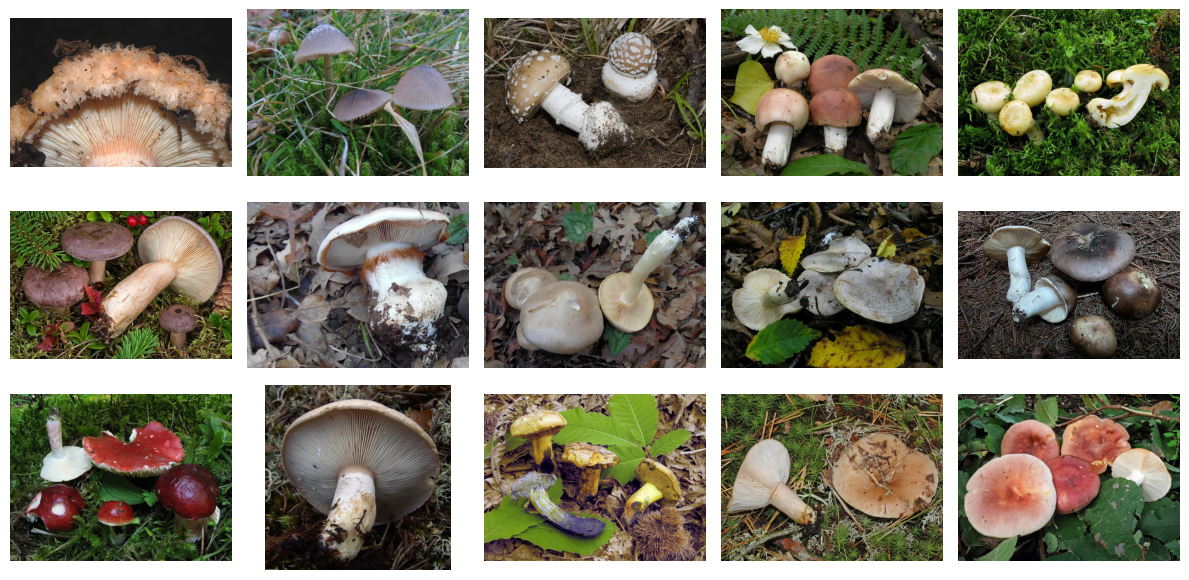

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def img_show(image_paths, nrows=3, ncols=5, figsize=(12, 6)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, path in enumerate(image_paths):
        if i >= nrows * ncols:
            break
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

img_show(train_image_paths[:15])

In [ ]:
train_image_paths[0].shape()

AttributeError: 'str' object has no attribute 'str'

데이터셋 사용할때 쓸 함수

In [ ]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

class MushroomDataset(Dataset):
    def __init__(self, image_paths, transforms):
        self.image_paths = image_paths
        self.transforms = transforms

    def __getitem__(self, index):
        path = self.image_paths[index]
        label = classes_index[os.path.basename(os.path.dirname(path))]

        image = Image.open(path).convert('RGB')
        image = self.transforms(image)
        return image, label

    def __len__(self):
        return len(self.image_paths)

세트로 나누기

In [ ]:
train_set = MushroomDataset(train_image_paths, train_transform)
test_set = MushroomDataset(test_image_paths, test_transform)

train_dataloader = DataLoader(train_set, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size = 32, shuffle = False)

Relu없이, CrossEntropyLoss, SGD

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model_ft = resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_features, len(classes))

model_ft = model_ft.to(device)

loss_fn = nn.CrossEntropyLoss()

optimiser = optim.SGD(model_ft.fc.parameters(), lr=0.01)

10번 반복학습

In [ ]:
epoches = 10

train_losses = []
test_losses = []
a = 0
for epoch in range(epoches):
    model_ft.train()
    # Accumlated loss from each batch
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_dataloader:
        optimiser.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        outputs = model_ft(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimiser.step()

        _, preds = torch.max(outputs.data, 1)

        train_loss += loss.item()
        train_correct += (preds == labels).sum().item()

        train_loss /= len(train_dataloader)
        train_accuracy = 100.0 * train_correct / len(train_image_paths)

        if a%100==0:
          print(a)
        a += 1

    model_ft.eval()
    test_loss = 0.0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_ft(images)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            test_loss += loss.item()
            test_correct += (preds == labels).sum().item()

    test_loss /= len(test_dataloader)
    test_accuracy = 100.0 * test_correct / len(test_image_paths)

    print(f'Epoch [{epoch + 1} / {epoches}], '
      f'Train Loss: {train_loss: .4f}, Train Accuracy: {train_accuracy: .2f}%, '
      f'Test Loss: {test_loss: .4f}, Test Accuracy: {test_accuracy: .2f}%')


0


KeyboardInterrupt: 